## Ridge, Lasso, Elastic Net

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

### 릿지(Ridge) 회귀 구현

사이킷런의 Ridge 클래스 사용해서 릿지 회귀 구현  
주요 생성 파라미터는 alpha: alpha L2 규제 계수에 해당

### 데이터 로드

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.linear_model import Ridge,Lasso,ElasticNet,LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [4]:
CS =  pd.read_csv('../data/CS.csv', encoding='EUC-KR')

### 데이터 확인

In [5]:
# 전체 데이터셋 크기 확인
CS.shape

(20624, 24)

In [6]:
# 시니어만 따로 추출, 수도권만 추출
senior_df = CS.copy()
senior_df = senior_df[(senior_df.age == 5) | (senior_df.age == 6)]
senior_df = senior_df[(senior_df.sido == 1) | (senior_df.sido == 9)]

In [7]:
# filtering 확인
senior_df['age'].value_counts().index

Int64Index([5, 6], dtype='int64')

In [8]:
# filtering 확인
senior_df['sido'].value_counts().index

Int64Index([9, 1], dtype='int64')

In [9]:
senior_df

,view_cnt,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt,standard,block,expense,expense_f,...,festival,festival_f,sex,age,education,married,work,income,sido,disabled
0,49,0,0,0,5,0,1,1,14,14,...,2,6,2,5,3,1,5,3,1,1
1,3,3,3,0,1,0,2,6,14,9,...,2,7,2,5,3,2,5,7,1,1
6,22,15,0,0,0,0,2,2,14,14,...,2,5,2,5,4,3,1,5,1,1
7,10,0,0,0,2,2,2,4,17,11,...,1,6,1,5,4,2,1,6,1,1
9,7,0,0,0,0,0,3,2,15,12,...,2,5,2,5,3,2,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20595,21,0,0,0,0,0,5,4,14,14,...,2,5,1,5,4,2,1,3,9,1
20599,23,0,0,0,1,0,1,1,17,14,...,2,5,2,5,3,2,1,6,9,1
20605,30,1,0,0,1,0,4,1,8,8,...,2,4,2,6,2,2,3,4,9,1
20618,7,2,0,0,4,0,1,2,16,16,...,2,5,2,5,3,2,3,6,1,1


In [10]:
senior_df.shape

(2144, 24)

#### view_cnt에 영향을 미치는 피처 확인

'\nsex\nage\neducation\nmarried\nwork\nincome\nsido\ndisabled\nexpense\nexpense_f\ndifficulty\nintention\nhistory\nhistory_f\nfestival\nfestival_f\n\n'

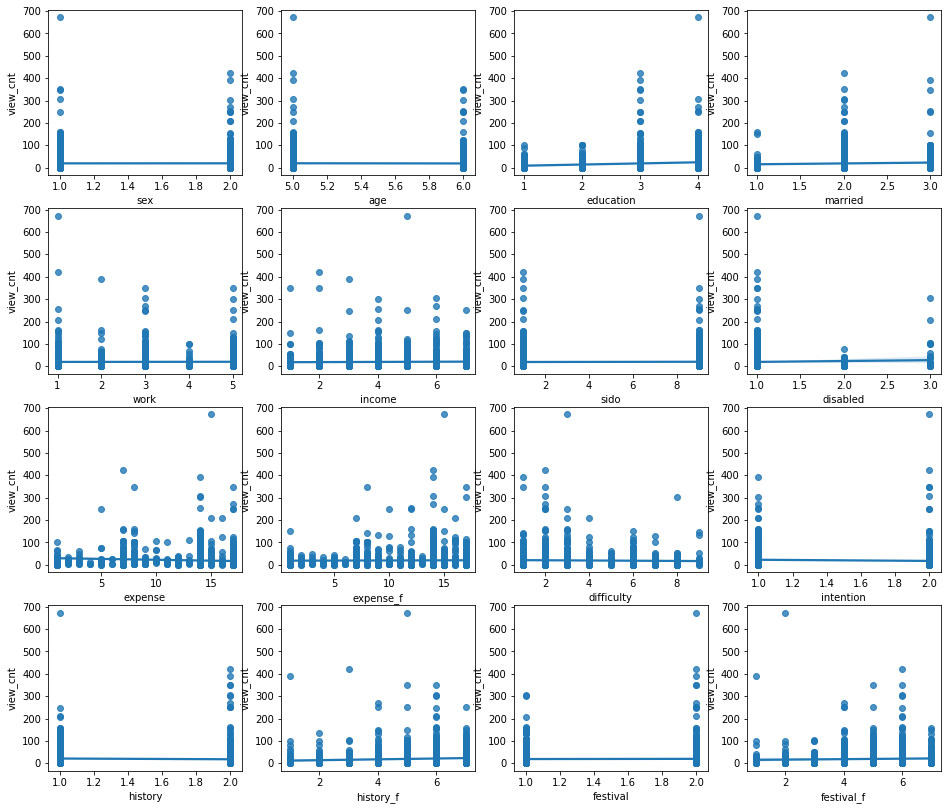

In [11]:
# 선택 피처 : 범주형 변수 모두

'''
sex
age
education
married
work
income
sido
disabled
expense
expense_f
difficulty
intention
history
history_f
festival
festival_f

'''
fig, axs = plt.subplots(figsize=(16,14), ncols=4, nrows=4)
lm_features = ['sex', 'age', 'education', 'married', 'work', 'income',
               'sido', 'disabled','expense', 'expense_f', 'difficulty', 'intention',
               'history', 'history_f', 'festival', 'festival_f']

# 각 요소에 대해
for i, feature in enumerate(lm_features) :
    row = int(i/4)
    col = i%4
    
    # 산점도와 선형 회귀 직선식 표시
    sns.regplot(x=feature, y='view_cnt', data=senior_df, ax=axs[row][col])

'\nwhere_cnt\nattend_cnt\nvolunteer_cnt\nhistory_cnt\nfestival_cnt\n\n'

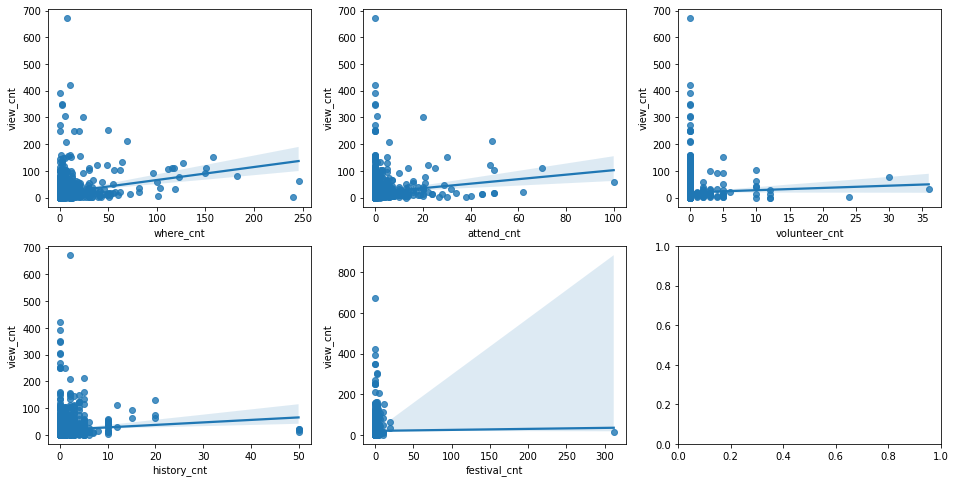

In [12]:
# 선택 피처 : 연속형 변수 모두

'''
where_cnt
attend_cnt
volunteer_cnt
history_cnt
festival_cnt

'''
fig, axs = plt.subplots(figsize=(16,8), ncols=3, nrows=2)
lm_features = ['where_cnt', 'attend_cnt', 'volunteer_cnt', 'history_cnt', 'festival_cnt']

# 각 요소에 대해
for i, feature in enumerate(lm_features) :
    row = int(i/3)
    col = i%3
    
    # 산점도와 선형 회귀 직선식 표시
    sns.regplot(x=feature, y='view_cnt', data=senior_df, ax=axs[row][col])

### 데이터 전처리

#### target 값 분포도 확인

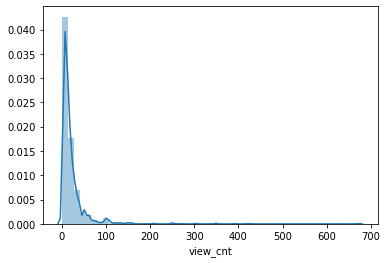

In [13]:
# 타깃값 view_cnt의 분포도 확인
sns.distplot(senior_df['view_cnt'])

#### target 범주화

In [14]:
# # 기존 데이터에 대한 기초통계량 출력
# CS['view_cnt'].describe()

# # 3개 카테고리로 나누기
# # 1 : 문화예술행사 관람을 적게 하는 사람
# # 2 : 문화예술행사 관람을 평범하게 하는 사람
# # 3 : 문화예술행사 관람을 많이 하는 사람

In [15]:
# # target 범주화
# target_min = min(CS['view_cnt'])
# target_max = max(CS['view_cnt'])

# target_ranges = [target_min-1, 7, 25, target_max+1]
# labels = [1, 2, 3,]
# senior_df['target'] = pd.cut(CS['view_cnt'], target_ranges, labels=labels)

In [16]:
# # 범주화 확인
# senior_df['target'].value_counts().sort_index()

#### log변환

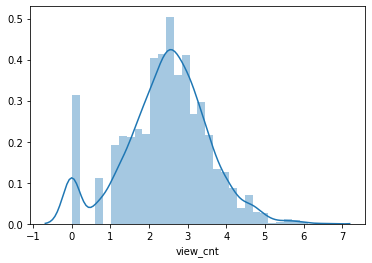

In [17]:
# target값을 로그 변환 후 view_cnt 값 분포도 확인
log_view_cnt = np.log1p(senior_df['view_cnt'])
sns.distplot(log_view_cnt)

# 로그 변환 결과
# 0 때문에 완벽한 정규 분포 형태는 아니지만, 어느 정도 정규 분포를 나타냄

In [18]:
# target : view_cnt 로그 변환
senior_df
senior_df['view_cnt_log'] = np.log1p(senior_df['view_cnt'])
senior_df[['age','sido','view_cnt_log']]

,view_cnt,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt,standard,block,expense,expense_f,...,festival,festival_f,sex,age,education,married,work,income,sido,disabled
0,49,0,0,0,5,0,1,1,14,14,...,2,6,2,5,3,1,5,3,1,1
1,3,3,3,0,1,0,2,6,14,9,...,2,7,2,5,3,2,5,7,1,1
6,22,15,0,0,0,0,2,2,14,14,...,2,5,2,5,4,3,1,5,1,1
7,10,0,0,0,2,2,2,4,17,11,...,1,6,1,5,4,2,1,6,1,1
9,7,0,0,0,0,0,3,2,15,12,...,2,5,2,5,3,2,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20595,21,0,0,0,0,0,5,4,14,14,...,2,5,1,5,4,2,1,3,9,1
20599,23,0,0,0,1,0,1,1,17,14,...,2,5,2,5,3,2,1,6,9,1
20605,30,1,0,0,1,0,4,1,8,8,...,2,4,2,6,2,2,3,4,9,1
20618,7,2,0,0,4,0,1,2,16,16,...,2,5,2,5,3,2,3,6,1,1


,age,sido,view_cnt_log
0,5,1,3.912023
1,5,1,1.386294
6,5,1,3.135494
7,5,1,2.397895
9,5,1,2.079442
...,...,...,...
20595,5,9,3.091042
20599,5,9,3.178054
20605,6,9,3.433987
20618,5,1,2.079442


In [19]:
# target
target = senior_df['view_cnt_log']

#### One-Hot Encoding
- 범주형 변수(features)에 적용
- sklearn 이용

In [40]:
# features : target, sido, age 제외
features = senior_df.drop(['view_cnt','view_cnt_log', 'age', 'sido'], axis=1)
features.head(1)

,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt,standard,block,expense,expense_f,difficulty,...,history,history_f,festival,festival_f,sex,education,married,work,income,disabled
0,0,0,0,5,0,1,1,14,14,3,...,1,6,2,6,2,3,1,5,3,1


In [42]:
features.iloc[:, :5].head(1)

,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt
0,0,0,0,5,0


In [43]:
# log 변환
features.iloc[:, :5] = np.log1p(features.iloc[:, :5])

# log 변환 확인
features.iloc[:, :5].head(2)

,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt
0,0.000000,0.000000,0.0,1.791759,0.0
1,1.386294,1.386294,0.0,0.693147,0.0


In [20]:
from sklearn.preprocessing import OneHotEncoder

In [45]:
features.iloc[:, 5:] = features.iloc[:, 5:].astype(dtype='object')

In [46]:
features.iloc[:, 5:].dtypes

standard      object
block         object
expense       object
expense_f     object
difficulty    object
intention     object
history       object
history_f     object
festival      object
festival_f    object
sex           object
education     object
married       object
work          object
income        object
disabled      object
dtype: object

In [47]:
# 원-핫 인코딩 수행 
print('get_dummies() 수행 전 데이터 Shape', features.shape)
features = pd.get_dummies(features)
print('get_dummies() 수행 후 데이터 Shape', features.shape)

# 결과
# 피처 21 -> 111

get_dummies() 수행 전 데이터 Shape (2144, 21)
get_dummies() 수행 후 데이터 Shape (2144, 111)


In [48]:
# Null 값을 가진 피처 확인
null_columnn_count = features.isnull().sum()[features.isnull().sum() > 0]
features.dtypes[null_columnn_count.index]

Series([], dtype: object)

### 전처리 작업 완료 
- 종속 변수는 로그 변환
- 독립 변수는 age 제외한 범주형 변수
- 범주형 변수에 대해 원-핫 인코딩 진행 

### Ridge, Lasso

#### RMSE 평가 함수

- RMSE : 숫자가 작을수록(1보다 작을수록) 성능이 좋다는 의미

In [49]:
# 학습된 모델을 받아서 예측하고 RMSE 반환

# 단일 모델의 RMSE 값 반환
def get_rmse(model): 
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    
    print('{0} 로그 변환된 RMSE :{1}'.format(model.__class__.__name__, 
                                        np.round(rmse, 3)))
    return rmse


# 여러 모델의 RMSE 값 반환
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model) # 단일 모델의 RMSE 값 반환하는 함수 호출
        rmses.append(rmse)

    return rmses


In [50]:
from sklearn.metrics import mean_squared_error, r2_score

# 학습/테스트 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(features ,
                                                       target, 
                                                       test_size=0.2, 
                                                       random_state=156) 
# Ridge, Lasso 

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

# 평가 함수 호출
models = [ridge_reg, lasso_reg]
get_rmses(models) # 학습된 모델 전달하고 RMSE 출력

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Ridge 로그 변환된 RMSE :0.969
Lasso 로그 변환된 RMSE :1.11


[0.969375811864271, 1.1102074699466067]

In [51]:
# 평가 - Ridge()
from sklearn.metrics import mean_squared_error, r2_score

y_pred = ridge_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# 평가 지표 출력
print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('R제곱 (Variance Score) : {0:.3f}'.format(r2_score(y_test, y_pred)))

# R제곱 : RMSE와 반대로 높을수록 좋은 지표이다. max는 1이다. 0~1 사이의 수치가 값으로 전달

MSE : 0.940, RMSE : 0.969
R제곱 (Variance Score) : 0.222


In [52]:
# 평가 - Lasso()
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lasso_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# 평가 지표 출력
print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('R제곱 (Variance Score) : {0:.3f}'.format(r2_score(y_test, y_pred)))

# R제곱 : RMSE와 반대로 높을수록 좋은 지표이다. max는 1이다. 0~1 사이의 수치가 값으로 전달

MSE : 1.233, RMSE : 1.110
R제곱 (Variance Score) : -0.021


In [54]:
# Ridge, Lasso 정확도 
print(ridge_reg.score(X_train,y_train))
print(lasso_reg.score(X_train,y_train))

0.2471069780791415
0.0


### Elastic Net

In [32]:
elasticnet = ElasticNet()
alphas = [0.07, 0.1, 0.5, 1, 3]
parameters = {'alpha' : alphas}


elasticnet_reg = GridSearchCV(elasticnet, parameters, scoring='neg_mean_squared_error', cv=5)
elasticnet_reg.fit(X_train, y_train)
print(elasticnet_reg.best_params_)
print(elasticnet_reg.best_score_)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.07, 0.1, 0.5, 1, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

{'alpha': 0.07}
-1.0456087134684247


### alpha값 조정, 교차 검증 실행
- Ridge, Lasso

In [33]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
# Ridge Regression
# select alpha 0.0001 or 0.001 or 0.01 by checking R2, MSE, RMSE
for a in alphas:
    model = Ridge(alpha=a).fit(X_train,y_train)
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_train)
    mse = mean_squared_error(y_train, pred_y)
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.30, MSE:0.83, RMSE:0.91
Alpha:0.0010, R2:0.30, MSE:0.83, RMSE:0.91
Alpha:0.0100, R2:0.30, MSE:0.83, RMSE:0.91
Alpha:0.1000, R2:0.30, MSE:0.83, RMSE:0.91
Alpha:0.3000, R2:0.30, MSE:0.84, RMSE:0.92
Alpha:0.5000, R2:0.30, MSE:0.84, RMSE:0.92
Alpha:0.7000, R2:0.29, MSE:0.84, RMSE:0.92
Alpha:1.0000, R2:0.29, MSE:0.85, RMSE:0.92


In [34]:
# 교차검증
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,ElasticNetCV

ridge_cv=RidgeCV(alphas=alphas, cv=5)
model = ridge_cv.fit(X_train, y_train)
print(model.alpha_)

1.0


In [35]:
# Ridge R2, MSE, RMSE 
ridge=Ridge(alpha=0.0001).fit(X_train, y_train)
ypred_ridge = ridge.predict(X_test)
score_ridge = ridge.score(X_test, y_test)
mse_ridge = mean_squared_error(y_test, ypred_ridge)
print("Final Result: Ridge R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
.format(score_ridge, mse_ridge, np.sqrt(mse_ridge)))

Final Result: Ridge R2:0.135, MSE:1.04, RMSE:1.02


In [40]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
# Ridge Regression
# select alpha 0.0001 or 0.001 or 0.01 by checking R2, MSE, RMSE
for a in alphas:
    model = Lasso(alpha=a).fit(X_train,y_train)
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_train)
    mse = mean_squared_error(y_train, pred_y)
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.25, MSE:0.90, RMSE:0.95
Alpha:0.0010, R2:0.24, MSE:0.90, RMSE:0.95
Alpha:0.0100, R2:0.19, MSE:0.96, RMSE:0.98
Alpha:0.1000, R2:0.10, MSE:1.08, RMSE:1.04
Alpha:0.3000, R2:0.03, MSE:1.16, RMSE:1.08
Alpha:0.5000, R2:0.00, MSE:1.19, RMSE:1.09
Alpha:0.7000, R2:0.00, MSE:1.19, RMSE:1.09
Alpha:1.0000, R2:0.00, MSE:1.19, RMSE:1.09


In [41]:
ridge_cv=RidgeCV(alphas=alphas, cv=5)
model = ridge_cv.fit(X_train, y_train)
print(model.alpha_)

1.0


In [42]:
# Lasso R2, MSE, RMSE 
lasso=Lasso(alpha=0.0001).fit(X_train, y_train)
ypred_lasso = lasso.predict(X_test)
score_lasso = lasso.score(X_test, y_test)
mse_lasso = mean_squared_error(y_test, ypred_ridge)
print("Final Result: Lasso R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
.format(score_lasso, mse_lasso, np.sqrt(mse_lasso)))

Final Result: Lasso R2:0.221, MSE:0.94, RMSE:0.97
